In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import svm
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_percentage_error



In [61]:
df = pd.read_excel("BaseFeaturesHH.xlsx")

df

,Unnamed: 0,From Timestamp,HH Electricity (kWh),dayofweek,hour,holiday,month,Temperature (C),Feels like (C),Humidity (%)
0,0,2018-01-01 00:00:00,12.80,0,0.0,1,1,6.4,1.9,82.76
1,1,2018-01-01 00:30:00,12.30,0,0.5,1,1,6.4,1.9,82.76
2,2,2018-01-01 01:00:00,13.50,0,1.0,1,1,6.6,2.4,80.14
3,3,2018-01-01 01:30:00,11.90,0,1.5,1,1,6.6,2.4,80.14
4,4,2018-01-01 02:00:00,12.80,0,2.0,1,1,6.1,2.0,84.33
...,...,...,...,...,...,...,...,...,...,...
35035,35035,2019-12-31 21:30:00,13.56,1,21.5,0,12,6.5,3.3,88.23
35036,35036,2019-12-31 22:00:00,13.81,1,22.0,0,12,6.6,4.4,87.69
35037,35037,2019-12-31 22:30:00,14.12,1,22.5,0,12,6.6,4.4,87.69
35038,35038,2019-12-31 23:00:00,14.50,1,23.0,0,12,6.7,4.1,88.13


In [62]:
feature_cols = ['dayofweek', 'hour', 'month', 'holiday', 'Temperature (C)', 'Feels like (C)', 'Humidity (%)']   

X = df[feature_cols].copy() #input features

Xtrain = df.iloc[:-(3*48)]
Xvalidate = df.iloc[-(3*48):]

X1 = Xtrain[feature_cols] # Features
y1 = Xtrain['HH Electricity (kWh)'] # Target variable

X2 = Xvalidate[feature_cols] # Features
y2 = Xvalidate['HH Electricity (kWh)'] # Target variable

scaler = StandardScaler() #scaling
scaler.fit(X)
X1scaled = scaler.transform(X1)
X2scaled = scaler.transform(X2)


from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X1scaled,y1,test_size=0.25,random_state=42) #split training:testing 75:25

# Random Forest Regressor

5.699406059145713


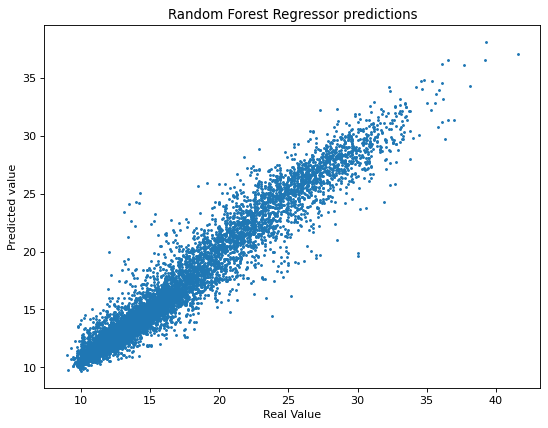

In [63]:
estimator = RandomForestRegressor(n_estimators = 700,  random_state=42).fit(X_train, y_train)
y_pred = estimator.predict(X_test)

RandomForestMAPE = mean_absolute_percentage_error(y_test, y_pred) * 100
print(RandomForestMAPE)

from matplotlib.pyplot import figure

figure(figsize=(8, 6), dpi=80)
plt.scatter(y_test,y_pred, s = 2.5)
plt.xlabel('Real Value')
# Set the y axis label of the current axis.
plt.ylabel('Predicted value')
# Set a title of the current axes.
plt.title('Random Forest Regressor predictions')
# Display a figure.
plt.show()

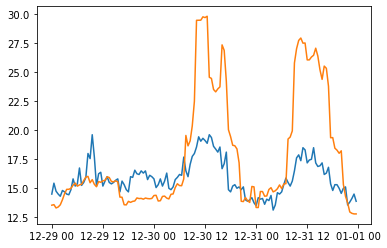

In [64]:
pred = estimator.predict(X2scaled)
plt.plot(df['From Timestamp'].iloc[-(3*48):],y2)
plt.plot(df['From Timestamp'].iloc[-(3*48):],pred)

# How is this only 5.7%??


In [65]:
RandomForestMAPE = mean_absolute_percentage_error(y2, pred) * 100
print(RandomForestMAPE)

17.851789188603316


In [67]:
import shap

shap.initjs()


In [68]:
X_importance = X_test

# Explain model predictions using shap library:
explainer = shap.TreeExplainer(estimator)
shap_values = explainer.shap_values(X_importance)


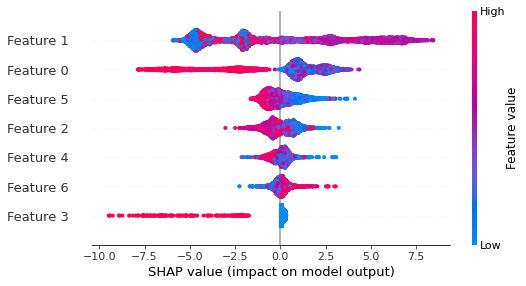

In [69]:
shap.summary_plot(shap_values, X_importance)

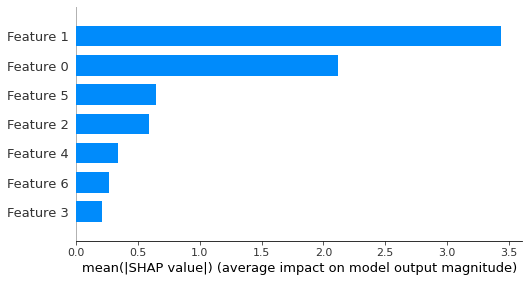

In [70]:
shap.summary_plot(shap_values, X_importance, plot_type='bar')

In [74]:
'dayofweek', 'hour', 'month', 'holiday', 'Temperature (C)', 'Feels like (C)', 'Humidity (%)'

,Unnamed: 0,From Timestamp,HH Electricity (kWh),dayofweek,hour,holiday,month,Temperature (C),Feels like (C),Humidity (%),n-48.,n-96.,n-144.,n-192.,n-240.,n-288.,n-336.
384,384,2018-01-09 00:00:00,13.5,1,0.0,0,1,3.9,0.1,90.94,13.90,11.5,12.50,13.7,13.60,14.1,12.40
385,385,2018-01-09 00:30:00,13.6,1,0.5,0,1,3.9,0.1,90.94,14.20,13.4,11.70,11.8,13.09,14.2,12.50
386,386,2018-01-09 01:00:00,14.0,1,1.0,0,1,3.9,0.2,91.64,13.80,11.7,11.59,12.5,13.20,13.8,12.41
387,387,2018-01-09 01:30:00,13.2,1,1.5,0,1,3.9,0.2,91.64,14.20,11.4,11.41,11.9,13.20,14.0,12.30
388,388,2018-01-09 02:00:00,13.1,1,2.0,0,1,3.9,0.3,91.88,13.41,11.5,11.50,12.8,13.09,15.5,12.70


# New try for forecasting by a day


In [11]:
df = pd.read_excel("HHwithExog.xlsx")

In [12]:
lagNumberStart = 48
lagNumberEnd = 96

for i in range(lagNumberStart-1, lagNumberEnd):
    name = "n-{}.".format(i+1)
    df[name] = df['HH Electricity (kWh)'].shift(i+1)
    
df

,From Timestamp,HH Electricity (kWh),dayofweek,hour,holiday,month,Temperature (C),Feels like (C),Humidity (%),n-48.,...,n-87.,n-88.,n-89.,n-90.,n-91.,n-92.,n-93.,n-94.,n-95.,n-96.
0,2018-01-01 00:00:00,12.80,0,0,1,1,6.4,1.9,82.76,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-01-01 00:30:00,12.30,0,0,1,1,6.4,1.9,82.76,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2018-01-01 01:00:00,13.50,0,0,1,1,6.6,2.4,80.14,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2018-01-01 01:30:00,11.90,0,0,1,1,6.6,2.4,80.14,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2018-01-01 02:00:00,12.80,0,0,1,1,6.1,2.0,84.33,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35035,2019-12-31 21:30:00,13.56,1,0,0,12,6.5,3.3,88.23,14.00,...,15.19,15.81,15.31,15.06,15.81,16.00,16.12,15.75,16.50,16.31
35036,2019-12-31 22:00:00,13.81,1,0,0,12,6.6,4.4,87.69,13.88,...,15.62,15.19,15.81,15.31,15.06,15.81,16.00,16.12,15.75,16.50
35037,2019-12-31 22:30:00,14.12,1,0,0,12,6.6,4.4,87.69,14.00,...,16.31,15.62,15.19,15.81,15.31,15.06,15.81,16.00,16.12,15.75
35038,2019-12-31 23:00:00,14.50,1,0,0,12,6.7,4.1,88.13,14.19,...,15.00,16.31,15.62,15.19,15.81,15.31,15.06,15.81,16.00,16.12


In [13]:
i = list(range(lagNumberEnd))
df = df.drop(i)

df


,From Timestamp,HH Electricity (kWh),dayofweek,hour,holiday,month,Temperature (C),Feels like (C),Humidity (%),n-48.,...,n-87.,n-88.,n-89.,n-90.,n-91.,n-92.,n-93.,n-94.,n-95.,n-96.
96,2018-01-03 00:00:00,14.10,2,0,0,1,10.8,10.8,79.42,12.40,...,11.90,11.91,13.00,11.90,12.60,12.80,11.90,13.50,12.30,12.80
97,2018-01-03 00:30:00,14.20,2,0,0,1,10.8,10.8,79.42,12.50,...,13.00,11.90,11.91,13.00,11.90,12.60,12.80,11.90,13.50,12.30
98,2018-01-03 01:00:00,13.80,2,0,0,1,10.1,10.1,78.30,12.41,...,13.10,13.00,11.90,11.91,13.00,11.90,12.60,12.80,11.90,13.50
99,2018-01-03 01:30:00,14.00,2,0,0,1,10.1,10.1,78.30,12.30,...,12.90,13.10,13.00,11.90,11.91,13.00,11.90,12.60,12.80,11.90
100,2018-01-03 02:00:00,15.50,2,0,0,1,9.7,5.6,76.36,12.70,...,13.60,12.90,13.10,13.00,11.90,11.91,13.00,11.90,12.60,12.80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35035,2019-12-31 21:30:00,13.56,1,0,0,12,6.5,3.3,88.23,14.00,...,15.19,15.81,15.31,15.06,15.81,16.00,16.12,15.75,16.50,16.31
35036,2019-12-31 22:00:00,13.81,1,0,0,12,6.6,4.4,87.69,13.88,...,15.62,15.19,15.81,15.31,15.06,15.81,16.00,16.12,15.75,16.50
35037,2019-12-31 22:30:00,14.12,1,0,0,12,6.6,4.4,87.69,14.00,...,16.31,15.62,15.19,15.81,15.31,15.06,15.81,16.00,16.12,15.75
35038,2019-12-31 23:00:00,14.50,1,0,0,12,6.7,4.1,88.13,14.19,...,15.00,16.31,15.62,15.19,15.81,15.31,15.06,15.81,16.00,16.12


In [15]:
feature_cols = ['dayofweek', 'hour', 'month', 'holiday', 'Temperature (C)', 'Feels like (C)', 'Humidity (%)']   

for i in range(lagNumberStart-1,lagNumberEnd):
    name = "n-{}.".format(i+1)
    feature_cols.append(name)
    
X = df[feature_cols] # Features
y = df['HH Electricity (kWh)'] # Target variable

scaler = StandardScaler() #scaling
X_scaled = scaler.fit_transform(X)


from sklearn.model_selection import train_test_split

#X1,X_Validate,y1,y_validate = train_test_split(X,y,test_size=0.2,random_state=42) #split training:testing:validation 60:20:20
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=42) #split training:testing 75:25

6.920477432753351


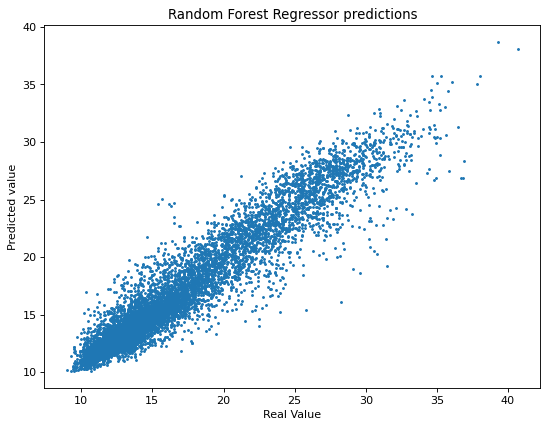

In [16]:
estimator = RandomForestRegressor(n_estimators = 700,  random_state=42).fit(X_train, y_train)
y_pred = estimator.predict(X_test)

RandomForestMAPE = mean_absolute_percentage_error(y_test, y_pred) * 100
print(RandomForestMAPE)

from matplotlib.pyplot import figure

figure(figsize=(8, 6), dpi=80)
plt.scatter(y_test,y_pred, s = 2.5)
plt.xlabel('Real Value')
# Set the y axis label of the current axis.
plt.ylabel('Predicted value')
# Set a title of the current axes.
plt.title('Random Forest Regressor predictions')
# Display a figure.
plt.show()

# Using the same hour of the days from the past week

5.6243999541263126


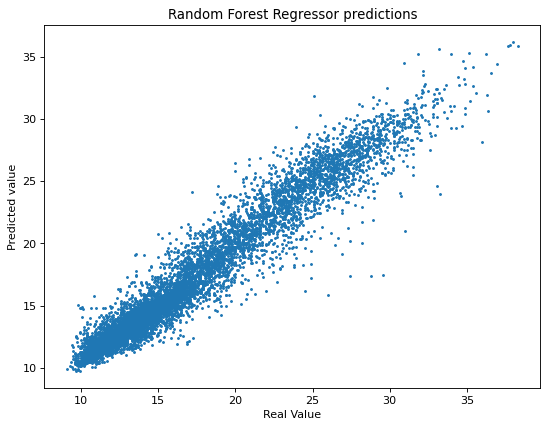

In [20]:
df = pd.read_excel("HHwithExog.xlsx")

lagNumberStart = 1
lagNumberEnd = 7

for i in range(lagNumberStart, lagNumberEnd):
    name = "n-{}.".format(48*i)
    df[name] = df['HH Electricity (kWh)'].shift(48*i)

i = list(range(lagNumberEnd*48))
df = df.drop(i)


feature_cols = ['dayofweek', 'hour', 'month', 'holiday', 'Temperature (C)', 'Feels like (C)', 'Humidity (%)']   

for i in range(lagNumberStart, lagNumberEnd):
    name = "n-{}.".format(48*i)
    feature_cols.append(name)
    
X = df[feature_cols] # Features
y = df['HH Electricity (kWh)'] # Target variable

scaler = StandardScaler() #scaling
X_scaled = scaler.fit_transform(X)


#X1,X_Validate,y1,y_validate = train_test_split(X,y,test_size=0.2,random_state=42) #split training:testing:validation 60:20:20
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=42) #split training:testing 75:25

estimator = RandomForestRegressor(n_estimators = 700,  random_state=42).fit(X_train, y_train)
y_pred = estimator.predict(X_test)

RandomForestMAPE = mean_absolute_percentage_error(y_test, y_pred) * 100
print(RandomForestMAPE)


figure(figsize=(8, 6), dpi=80)
plt.scatter(y_test,y_pred, s = 2.5)
plt.xlabel('Real Value')
# Set the y axis label of the current axis.
plt.ylabel('Predicted value')
# Set a title of the current axes.
plt.title('Random Forest Regressor predictions')
# Display a figure.
plt.show()



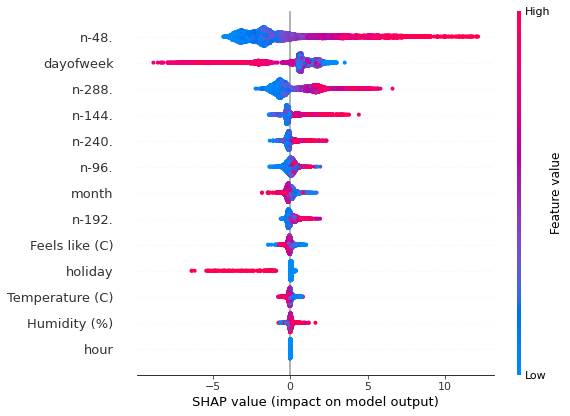

In [21]:
import shap

shap.initjs()

X_importance = X_test

# Explain model predictions using shap library:
explainer = shap.TreeExplainer(estimator)
shap_values = explainer.shap_values(X_importance)

shap.summary_plot(shap_values, X_importance)




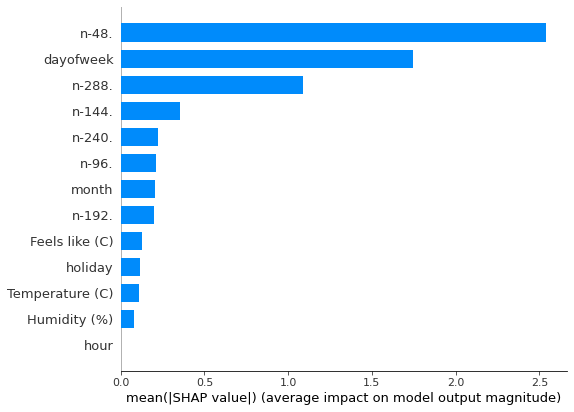

In [22]:
shap.summary_plot(shap_values, X_importance, plot_type='bar')

5.510781655821406


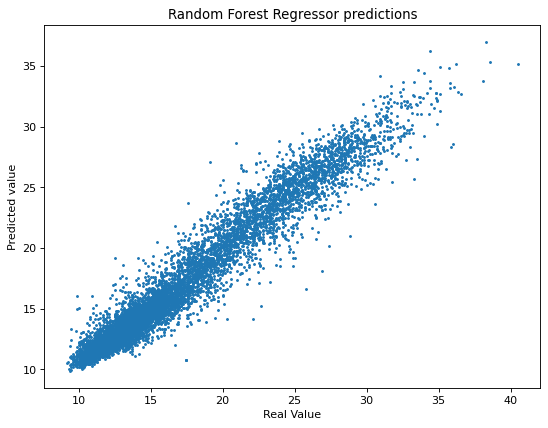

In [71]:
df = pd.read_excel("BaseFeaturesHH.xlsx")

lagNumberStart = 1
lagNumberEnd = 8

for i in range(lagNumberStart, lagNumberEnd):
    name = "n-{}.".format(48*i)
    df[name] = df['HH Electricity (kWh)'].shift(48*i)

i = list(range(lagNumberEnd*48))
df = df.drop(i)


feature_cols = ['dayofweek', 'hour', 'month', 'holiday', 'Temperature (C)', 'Feels like (C)', 'Humidity (%)']   

for i in range(lagNumberStart, lagNumberEnd):
    name = "n-{}.".format(48*i)
    feature_cols.append(name)
 

X = df[feature_cols].copy() #input features for fitting

Xtrain = df.iloc[:-(3*48)]
Xvalidate = df.iloc[-(3*48):]

X1 = Xtrain[feature_cols] # Features
y1 = Xtrain['HH Electricity (kWh)'] # Target variable

X2 = Xvalidate[feature_cols] # Features
y2 = Xvalidate['HH Electricity (kWh)'] # Target variable

scaler = StandardScaler() #scaling
scaler.fit(X)
X1scaled = scaler.transform(X1)
X2scaled = scaler.transform(X2)


from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X1scaled,y1,test_size=0.25,random_state=42) #split training:testing 75:25


estimator = RandomForestRegressor(n_estimators = 700,  random_state=42).fit(X_train, y_train)
y_pred = estimator.predict(X_test)

RandomForestMAPE = mean_absolute_percentage_error(y_test, y_pred) * 100
print(RandomForestMAPE)


figure(figsize=(8, 6), dpi=80)
plt.scatter(y_test,y_pred, s = 2.5)
plt.xlabel('Real Value')
# Set the y axis label of the current axis.
plt.ylabel('Predicted value')
# Set a title of the current axes.
plt.title('Random Forest Regressor predictions')
# Display a figure.
plt.show()

6.939974601366513


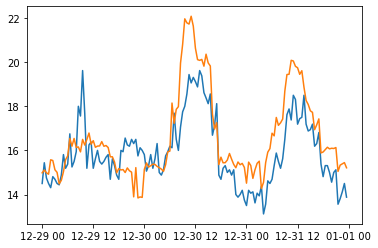

In [72]:
pred = estimator.predict(X2scaled)

RandomForestMAPE = mean_absolute_percentage_error(y2, pred) * 100
print(RandomForestMAPE)

plt.plot(df['From Timestamp'].iloc[-(3*48):],y2, label = True)
plt.plot(df['From Timestamp'].iloc[-(3*48):],pred, label = True)



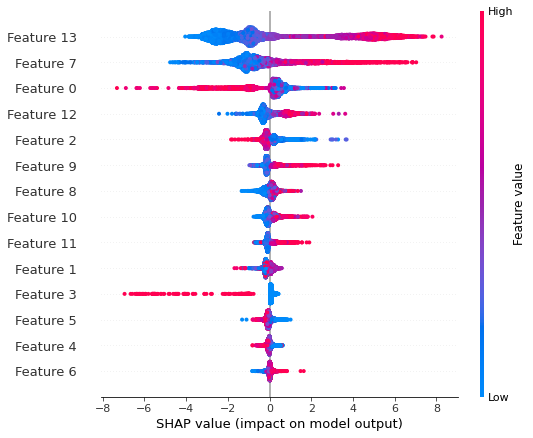

In [73]:
shap.initjs()

X_importance = X_test

# Explain model predictions using shap library:
explainer = shap.TreeExplainer(estimator)
shap_values = explainer.shap_values(X_importance)

shap.summary_plot(shap_values, X_importance)


In [75]:
df.head()

,Unnamed: 0,From Timestamp,HH Electricity (kWh),dayofweek,hour,holiday,month,Temperature (C),Feels like (C),Humidity (%),n-48.,n-96.,n-144.,n-192.,n-240.,n-288.,n-336.
384,384,2018-01-09 00:00:00,13.5,1,0.0,0,1,3.9,0.1,90.94,13.90,11.5,12.50,13.7,13.60,14.1,12.40
385,385,2018-01-09 00:30:00,13.6,1,0.5,0,1,3.9,0.1,90.94,14.20,13.4,11.70,11.8,13.09,14.2,12.50
386,386,2018-01-09 01:00:00,14.0,1,1.0,0,1,3.9,0.2,91.64,13.80,11.7,11.59,12.5,13.20,13.8,12.41
387,387,2018-01-09 01:30:00,13.2,1,1.5,0,1,3.9,0.2,91.64,14.20,11.4,11.41,11.9,13.20,14.0,12.30
388,388,2018-01-09 02:00:00,13.1,1,2.0,0,1,3.9,0.3,91.88,13.41,11.5,11.50,12.8,13.09,15.5,12.70


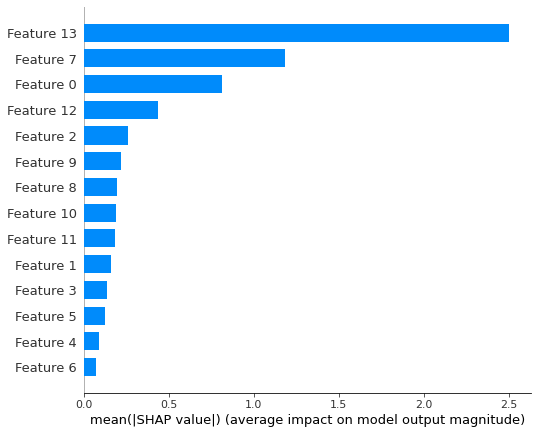

In [76]:
shap.summary_plot(shap_values, X_importance, plot_type='bar')

# Analysing the distribution of the dataset

Text(0.5, 1.0, 'Entire Dataset')

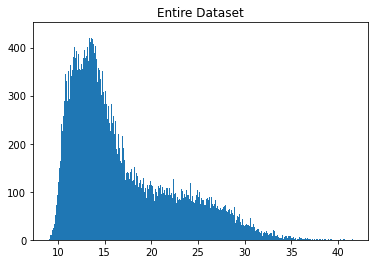

In [58]:
distribution = df['HH Electricity (kWh)'].round(decimals=1)
plt.hist(distribution, bins = 325)
plt.title('Entire Dataset')



Text(0.5, 1.0, 'Train Dataset')

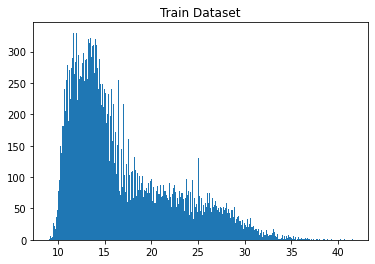

In [56]:
plt.hist(y_train, bins = 330)
plt.title('Train Dataset')

Text(0.5, 1.0, 'Test Dataset')

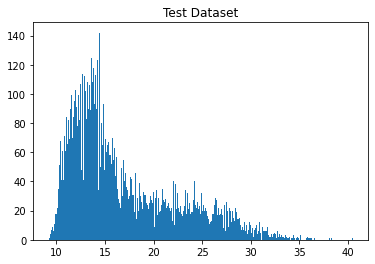

In [54]:
plt.hist(y_test, bins = 330)
plt.title('Test Dataset')

Text(0.5, 1.0, 'Predicted Values')

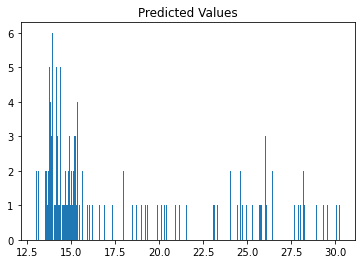

In [59]:
plt.hist(pred, bins = 330)
plt.title('Predicted Values')